In [ ]:
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/data_worthcheck/'

/content/drive/My Drive/data_worthcheck


## Read The Data

In [ ]:
import pandas as pd

### Read train file
train = pd.read_csv('train.csv')
train.drop(['Unnamed: 0'], axis=1, inplace=True)
train.rename(columns={'text_a': 'text'}, inplace=True)
train.label.replace({'no': 0, 'yes': 1}, inplace=True)

# ### Lowercase tiap kata pada train.text
# train.text = train.text.apply(lambda sentence: sentence.lower())

train.head(4)

,text,label
0,betewe buka twitter cuman ngetweet liat home b...,0
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,0
2,e100ss gini buka informasi sejelas nya identit...,1
3,neng solo wes ono terduga corona cobo neng ati...,0


In [ ]:
### Read test file
test = pd.read_csv('test.csv')
test.rename(columns={'text_a': 'text'}, inplace=True)
test.label.replace({'no': 0, 'yes': 1}, inplace=True)

# ### Lowercase tiap kata pada test.text
# test.text = test.text.apply(lambda sentence: sentence.lower())

test.head(4)

,text,label
0,jek dajal ga depok bang,0
1,detikcom untung depok masuk wilayah nya ridwan...,0
2,df dom jakarta depok yg gunain vc cabang nya c...,0
3,your2rl depok jkt,0


## Data Preprocessing

In [ ]:
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'], quiet=True)

True

In [ ]:
### Membuat kamus token dari dataset
from nltk.tokenize import word_tokenize

vocabs = []
for text in train.text:
  vocabs.append(word_tokenize(text))

len(vocabs)

21601

In [ ]:
### Penanganan kasus dimana text terbagi menjadi dua, seperti covid 19 yang
### yang seharusnya merupakan satu kalimat menggunakan bigrams

bigrams_vocabs = []
for text in train.text:
  bigrams_vocabs.append(list(nltk.bigrams(word_tokenize(text))))

print('Bigrams vocab | len:', len(bigrams_vocabs))

### Kurang tau contoh kasusnya seperti apa, tapi buat jaga2 buat dlu aja hehe
trigrams_vocabs = []
for text in train.text:
  trigrams_vocabs.append(nltk.trigrams(word_tokenize(text)))

print('Trigrams vocab | len:', len(trigrams_vocabs))

Bigrams vocab | len: 21601
Trigrams vocab | len: 21601


## Implementation of Word Embedding with Gensim Word2Vec Model

In [ ]:
### Membuat model Word2Vec berdasarkan vocabs yang tersedia
from gensim.models.word2vec import Word2Vec

nlp_model = Word2Vec(vocabs, size=300, window=5, min_count=5, iter=5)

In [ ]:
nlp_model.most_similar('twitter', topn=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('gaji', 0.9986997842788696),
 ('tukang', 0.9977389574050903),
 ('zaman', 0.997003436088562),
 ('tlg', 0.9967533946037292),
 ('ngeles', 0.9967269897460938)]

In [ ]:
### Membuat indexed dictionary
from tensorflow.keras import preprocessing

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(vocabs)
indexed_vocabulary = tokenizer.word_index

In [ ]:
### Buat text menjadi sequence of index memanfaatkan indexed_vocabulary
### Get index from text

texts_index = tokenizer.texts_to_sequences(vocabs)

### Menambahkan padding pada tiap texts_index yang terdapat pada vocabs

X_train = preprocessing.sequence.pad_sequences(texts_index, maxlen=28, padding='post', truncating='post')

In [ ]:
### Let's see what it is looks like

idx = 0
print('Text:', train.text.iloc[idx])
print('Seq:', X_train[idx])

print('\nCheck the index from indexed_vocabulary:')

for word in word_tokenize(train.text[idx]):
  print(word, ':', indexed_vocabulary[word])

Text: betewe buka twitter cuman ngetweet liat home berita corona panik kepikiran ndamau buka2 home yg aware aja i ll stay at home nda rumah kalo nda penting2 banget
Seq: [14225   134   536   631  6859   180   764    64     1   125  1685 14226
 14227   764     6  1570    15   217  6860   259   537   764  2772    37
    26  2772 10051    70]

Check the index from indexed_vocabulary:
betewe : 14225
buka : 134
twitter : 536
cuman : 631
ngetweet : 6859
liat : 180
home : 764
berita : 64
corona : 1
panik : 125
kepikiran : 1685
ndamau : 14226
buka2 : 14227
home : 764
yg : 6
aware : 1570
aja : 15
i : 217
ll : 6860
stay : 259
at : 537
home : 764
nda : 2772
rumah : 37
kalo : 26
nda : 2772
penting2 : 10051
banget : 70


In [ ]:
### Membuat embedding yang berisi hasil Word2Vec berdasarkan 
### indexed vocabulary yang tersedia

### Inisialisasi matriks embedding dengan 0 berukuran
### (length of vocabulary x vector size)
import numpy as np

embeddings = np.zeros((1+len(indexed_vocabulary), 300))

for word, idx in indexed_vocabulary.items():
  try:
    embeddings[idx] = nlp_model[word]
  except:
    pass

embeddings.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


(46616, 300)

## Preprocessing for Test Dataset

In [ ]:
vocabs_test = []
for text in test.text:
  vocabs_test.append(word_tokenize(text))

len(vocabs_test)

2800

In [ ]:
tests_index = tokenizer.texts_to_sequences(vocabs_test)

X_test = preprocessing.sequence.pad_sequences(tests_index, maxlen=28, padding='post', truncating='post')

X_test.shape

(2800, 28)

## Plot the NLP Model into Canvas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


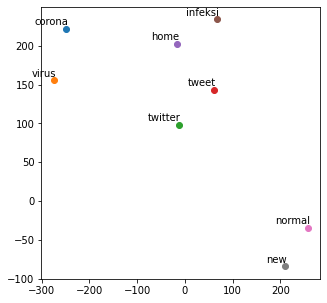

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def nlp_model_plot(vocab):
  labels = []
  wordvecs = []

  for word in vocab:
    try:
      wordvecs.append(nlp_model[word])
      labels.append(word)
    except:
      pass

  tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
  coordinates = tsne_model.fit_transform(wordvecs)

  x = []
  y = []
  for value in coordinates:
    x.append(value[0])
    y.append(value[1])
  
  plt.figure(figsize=(5,5))
  for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i],y[i]),
                 xytext=(2,2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
  
  plt.show()

vocab =['corona', 'virus',
        'twitter', 'tweet',
        'home', 'infeksi',
        'normal', 'new']
nlp_model_plot(vocab)

## Experiment the NLP Model

In [ ]:
vec = nlp_model['virus'] + nlp_model['rs']
nlp_model.most_similar([vec])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('terkena', 0.9811563491821289),
 ('menangani', 0.969197690486908),
 ('virus', 0.9690920114517212),
 ('taubat', 0.9653226137161255),
 ('carrier', 0.9651033878326416),
 ('terpapar', 0.9638115167617798),
 ('terinfeksi', 0.9621962308883667),
 ('semoga', 0.9617286324501038),
 ('terjangkit', 0.9615384340286255),
 ('dinyatakan', 0.9610744714736938)]

## Deep Learning

In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential([
  layers.Input(shape=X_train.shape[1]),
  layers.Embedding(input_dim=embeddings.shape[0],
                     output_dim=embeddings.shape[1],
                     weights=[embeddings],
                     input_length=28,
                     trainable=False),
  layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True)),
  layers.Bidirectional(layers.LSTM(units=15, dropout=0.2)),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 28, 300)           13984800  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 28, 30)            37920     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 30)                5520      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                1984      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 14,030,289
Trainable params: 45,489
Non-trainable params: 13,984,800
_________________________________________________________________


In [ ]:
model.fit(x=X_train, y=train.label, batch_size=256,
          epochs=10, shuffle=True, validation_split=0.3)

Epoch 1/10
60/60 [==============================] - 21s 211ms/step - loss: 0.4680 - accuracy: 0.8040 - val_loss: 0.4787 - val_accuracy: 0.7858
Epoch 2/10
60/60 [==============================] - 11s 183ms/step - loss: 0.3848 - accuracy: 0.8325 - val_loss: 0.4491 - val_accuracy: 0.7897
Epoch 3/10
60/60 [==============================] - 11s 179ms/step - loss: 0.3788 - accuracy: 0.8348 - val_loss: 0.4221 - val_accuracy: 0.7996
Epoch 4/10
60/60 [==============================] - 11s 180ms/step - loss: 0.3647 - accuracy: 0.8416 - val_loss: 0.4181 - val_accuracy: 0.8135
Epoch 5/10
60/60 [==============================] - 11s 181ms/step - loss: 0.3590 - accuracy: 0.8440 - val_loss: 0.4102 - val_accuracy: 0.8131
Epoch 6/10
60/60 [==============================] - 11s 182ms/step - loss: 0.3540 - accuracy: 0.8474 - val_loss: 0.3783 - val_accuracy: 0.8314
Epoch 7/10
60/60 [==============================] - 11s 182ms/step - loss: 0.3491 - accuracy: 0.8479 - val_loss: 0.3821 - val_accuracy: 0.8269

In [ ]:
predict = model.predict(X_test)

predict.shape

(2800, 1)

In [ ]:
threshold = 0.8

for i in range(len(predict)):
  x = predict[i][0]
  if(x >= threshold):
    print(test.text[i])

doakan indonesia selamat virus corona pkb depok gelar nusantara bershalawat
tetangga 2 pasien corona depok diimbau rumah 14 14 warga tinggal rumah pasien corona depok jawa barat diimbau aktivitas petugas dinas kesehatan sumber merdeka com
putraerlangga gubernur jabar ridwankamil virus corona bln hadir kota depok panik beliau warga antisipasi aja
konologi 2 wni positif terkena virus corona
jokowi wni terjangkit virus corona
cegah virus corona simak kebiasaan kim kardashian darisuara
info masyarakat kota bitung tercinta covid 19 covid corona marijokekotabitung colorfulbitung kotabitung bitung kotamanado airmadidi tomohon manado tondano amurang ratahan marijokabitung pesona bitungbahariberseri kotatomohon
membangun bisnis bangun aset digital wabah virus corona melanda dunia
jawa timur sehat indonesia maju kapolda jatim forkopimda jawa timur menggelar rangkaian gerakan jatimsehat acara maksudkan menyikapi nya kepanikan masyarakat virus corona jatimsehat semogajatimselalusehat
antisipasi co